### Importing

In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image
import matplotlib.pyplot as plt

### Display Image Function

In [2]:
# Function to display images
def show_image(img, title="Image", cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

### Feature Extraction using ResNet

In [3]:
def feature_extraction(image_path):
    # Load a pretrained ResNet model
    model = resnet50(pretrained=True)
    model.eval()

    # Define a transform to preprocess the input image
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load and preprocess the image
    image = Image.open(image_path)
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Forward pass through the model
    with torch.no_grad():
        features = model(input_batch)

    # Extract features from the last fully connected layer
    feature_vector = features.squeeze().numpy()
    print("Feature vector shape:", feature_vector.shape)

     # Visualize the features (projected back onto the image for simplicity)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    keypoints = [cv2.KeyPoint(x=int(feature_vector[i] % img.shape[1]), y=int(feature_vector[i] // img.shape[1]), _size=10) for i in range(min(50, len(feature_vector)))]
    img_with_features = cv2.drawKeypoints(img, keypoints, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
    
    return img_with_features

### Edge Detection using Sobel Operator

In [4]:
def edge_detection(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    preprocess = transforms.ToTensor()
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Define the Sobel operator kernels
    sobel_x = torch.tensor([[-1., 0., 1.],
                            [-2., 0., 2.],
                            [-1., 0., 1.]]).unsqueeze(0).unsqueeze(0)
    sobel_y = torch.tensor([[-1., -2., -1.],
                            [0., 0., 0.],
                            [1., 2., 1.]]).unsqueeze(0).unsqueeze(0)

    # Apply Sobel operators
    grad_x = F.conv2d(input_tensor, sobel_x, padding=1)
    grad_y = F.conv2d(input_tensor, sobel_y, padding=1)

    # Calculate the gradient magnitude
    grad_magnitude = torch.sqrt(grad_x**2 + grad_y**2).squeeze().numpy()

    return grad_magnitude

### Structure from Motion (SfM)

In [5]:
def structure_from_motion(image_path1, image_path2):
    # Load images
    img1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)

    # Detect ORB keypoints and descriptors
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    # Match descriptors using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Convert keypoints to points
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

    # Compute the essential matrix
    E, mask = cv2.findEssentialMat(points1, points2, focal=1.0, pp=(0, 0), method=cv2.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, mask = cv2.recoverPose(E, points1, points2)

    # Assuming K is the camera intrinsic matrix
    K = np.array([[1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1]], dtype=float)

    # Projection matrices
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = np.hstack((R, t))

    # Triangulate points
    points1 = points1[mask.ravel() == 1]
    points2 = points2[mask.ravel() == 1]
    points4D = cv2.triangulatePoints(P1, P2, points1.T, points2.T)
    points3D = points4D[:3] / points4D[3]

    return img_matches, points3D.T

### Multi-View Stereo (MVS)

In [6]:
class SimpleDepthNet(nn.Module):
    def __init__(self):
        super(SimpleDepthNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

def dense_reconstruction(image_path):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Initialize and run the network
    model = SimpleDepthNet()
    output = model(input_tensor)
    depth_map = output.squeeze().detach().numpy()

    return depth_map

### Execution

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature vector shape: (1000,)


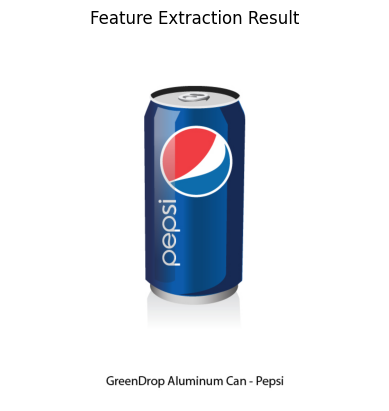

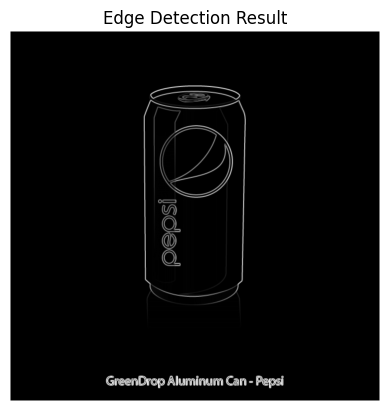

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\triangulate.cpp:64: error: (-210:Unsupported format or combination of formats) Input parameters must be matrices in function 'icvTriangulatePoints'


In [7]:
image_path1 = './productImages/pepsi.jpg'
image_path2 = './productImages/pepsi.jpg'

# Step 1: Feature Extraction
image = feature_extraction(image_path1)
show_image(image, "Feature Extraction Result")

# Step 2: Edge Detection
edges = edge_detection(image_path1)
show_image(edges, "Edge Detection Result", cmap='gray')

# Step 3: Structure from Motion
img_matches, points3D = structure_from_motion(image_path1, image_path2)
show_image(img_matches, "Feature Matching Result")
print("3D Points:\n", points3D)

# Step 4: Multi-View Stereo
depth_map = dense_reconstruction(image_path1)
show_image(depth_map, "Dense Reconstruction Result", cmap='gray')